In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy

import matplotlib.pyplot as plt

import iris
import iris.plot as iplt
import seaborn as sns

In [2]:
%matplotlib inline

In [23]:
hist_ohc_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/historical/yr/ocean/r1i1p1/ohc/latest/dedrifted/ohc-diff_Oyr_CanESM2_historical_r1i1p1_1861-2005.nc'
ghg_ohc_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/historicalGHG/yr/ocean/r1i1p1/ohc/latest/dedrifted/ohc-diff_Oyr_CanESM2_historicalGHG_r1i1p1_1861-2005.nc'
aa_ohc_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/historicalMisc/yr/ocean/r1i1p4/ohc/latest/dedrifted/ohc-diff_Oyr_CanESM2_historicalMisc_r1i1p4_1861-2005.nc'

In [24]:
hist_ohc_cube = iris.load_cube(hist_ohc_file, 'ocean heat content')
ghg_ohc_cube = iris.load_cube(ghg_ohc_file, 'ocean heat content')
aa_ohc_cube = iris.load_cube(aa_ohc_file, 'ocean heat content')
coord_names = [coord.name() for coord in ohc_cube.dim_coords]

In [16]:
coord_names

['depth', 'latitude', 'longitude']

In [17]:
ohc_cube.coord('depth')[-1]

DimCoord(array([5233.29980469]), bounds=array([[5038.        , 5428.59960938]]), standard_name='depth', units=Unit('m'), long_name='ocean depth coordinate', var_name='lev', attributes={'positive': 'down'})

## Depth plot

In [25]:
hist_depth_cube = hist_ohc_cube.collapsed(coord_names[1:], iris.analysis.SUM)
ghg_depth_cube = ghg_ohc_cube.collapsed(coord_names[1:], iris.analysis.SUM)
aa_depth_cube = aa_ohc_cube.collapsed(coord_names[1:], iris.analysis.SUM)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


In [19]:
def make_grid(depth_values):
    """Make a dummy cube with desired grid."""
       
    depth = iris.coords.DimCoord(depth_values,
                                 standard_name='depth',
                                 units='m',
                                 long_name='ocean depth coordinate',
                                 var_name='lev')

    dummy_data = numpy.zeros(len(depth_values))
    new_cube = iris.cube.Cube(dummy_data, dim_coords_and_dims=[(depth, 0)])

    new_cube.coord('depth').guess_bounds()

    return new_cube


def regrid(cube, ref_cube):
    """Regrid to reference grid, preserving the data sum"""

    depth_bounds = cube.coord('depth').bounds
    depth_diffs = numpy.apply_along_axis(lambda x: x[1] - x[0], 1, depth_bounds)
    cube_scaled = cube / depth_diffs

    ref_points = [('depth', ref_cube.coord('depth').points)]
    cube_regridded = cube_scaled.interpolate(ref_points, iris.analysis.Linear())         

    ref_depth_bounds = ref_cube.coord('depth').bounds
    ref_depth_diffs = numpy.apply_along_axis(lambda x: x[1] - x[0], 1, ref_depth_bounds)
    new_cube = cube_regridded * ref_depth_diffs

    return new_cube

In [20]:
new_grid = make_grid(numpy.arange(1, 5500, 2))

In [26]:
new_hist_depth_cube = regrid(hist_depth_cube, new_grid)
new_ghg_depth_cube = regrid(ghg_depth_cube, new_grid)
new_aa_depth_cube = regrid(aa_depth_cube, new_grid)

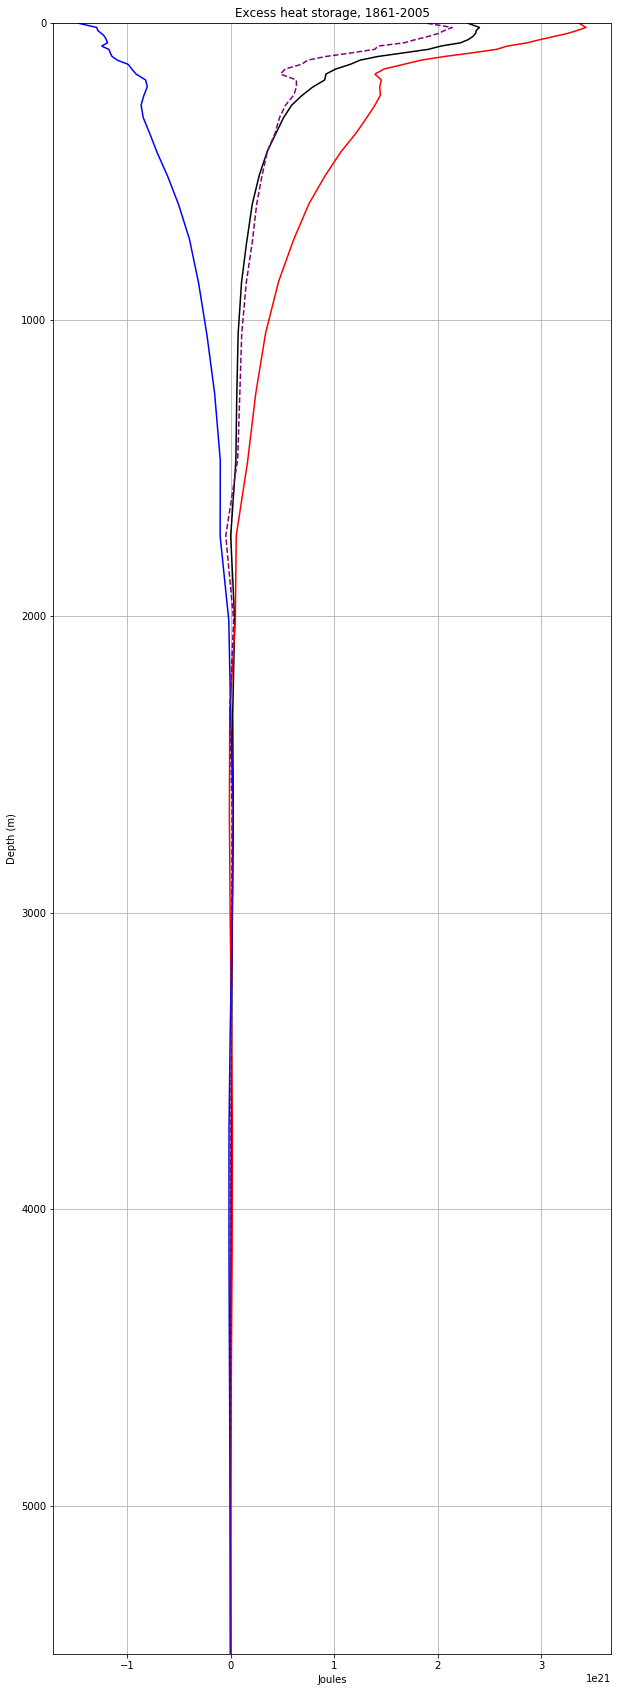

In [32]:
fig = plt.figure(figsize=[10, 30])

ydata = new_hist_depth_cube.coord('depth').points
hist_xdata = new_hist_depth_cube.data
ghg_xdata = new_ghg_depth_cube.data
aa_xdata = new_aa_depth_cube.data

plt.plot(hist_xdata, ydata, label='historical', color='black')
plt.plot(ghg_xdata, ydata, label='GHG-only', color='red')
plt.plot(aa_xdata, ydata, label='AA-only', color='blue')
plt.plot(aa_xdata + ghg_xdata, ydata, label='GHG + AA', color='purple', linestyle='dashed')
plt.gca().invert_yaxis()

plt.ylim([5500, 0])
#plt.xlim([-0.1e21, 0.2e21])

plt.grid(True)
#plt.axvline(0, color='0.5', linestyle='dashed')
plt.xlabel('Joules')
plt.ylabel('Depth (m)')
plt.title('Excess heat storage, 1861-2005')
plt.show()

In [12]:
depth_cube.data.sum()

3.190530943819972e+23

In [13]:
new_depth_cube.data.sum()

3.20643933644053e+23

It seems like the temporal differences between GHG forcing and AA forcing are evident in the vertical structure. In particular, AA forcing has plateaued in recent decades while GHG forcing has accelerated, which means more of the GHG storage is in the upper ocean (it hasn't had time to be trasported). Conversely, when you get down towards 1800m, AA forcing is larger than GHG forcing.